In [244]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [245]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_datamodule
import gz3d_pytorch_model
import train

In [246]:
df = pd.read_parquet('/Users/user/repos/zoobot-3d/data/gz3d_and_desi_master_catalog.parquet')
df = df[df['smooth-or-featured_featured-or-disk_fraction'] > 0.5]
df = df[df['disk-edge-on_yes_fraction'] < 0.5]
df = df[df['has-spiral-arms_yes_fraction'] > 0.5]
len(df)

80286

In [247]:
image_size = 128
base_dir = '/Users/user/repos/zoobot-3d/'
# adjust paths for base_dir
df['spiral_mask_loc'] = df['relative_spiral_mask_loc'].astype(str).apply(lambda x: base_dir + x)
df['bar_mask_loc'] = df['relative_bar_mask_loc'].astype(str).apply(lambda x: base_dir + x)
df['desi_jpg_loc'] = df.apply(lambda x: train.get_jpg_loc(x, base_dir), axis=1)

In [248]:

transform = train.default_segmentation_transforms(resize_after_crop=image_size)

datamodule = pytorch_datamodule.SegmentationDataModule(
    train_catalog=df[:100],
    val_catalog=df[200:300],
    test_catalog=df[300:400],
    batch_size=50,
    num_workers=1,
    # label_cols=label_cols,
    transform=transform
)
datamodule.setup('fit')

for batch in datamodule.train_dataloader():
    break  # gets batch variable

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [249]:
batch

{'image': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0706, 0.1608, 0.0980],
           [0.0000, 0.0000, 0.0000,  ..., 0.0706, 0.0353, 0.0745],
           [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0745, 0.0275]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.1137, 0.0627],
           [0.0000, 0.0000, 0.0000,  ..., 0.0902, 0.0392, 0.0667],
           [0.0000, 0.0000, 0.0000,  ..., 0.0863, 0.0863, 0.0431]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0

In [250]:
model = gz3d_pytorch_model.ZooBot3D(
    input_size=image_size,
    n_classes=2,
    skip_connection_weighting=1
)

In [251]:
forward_output = model(batch['image'])

In [252]:
forward_spiral_pred = forward_output[0, 0].detach().numpy()

(-0.5, 127.5, 127.5, -0.5)

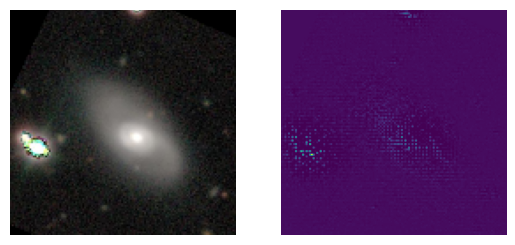

In [253]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.imshow(batch['image'][0].permute(1, 2, 0))
ax1.imshow(forward_spiral_pred)
ax0.axis('off')
ax1.axis('off')

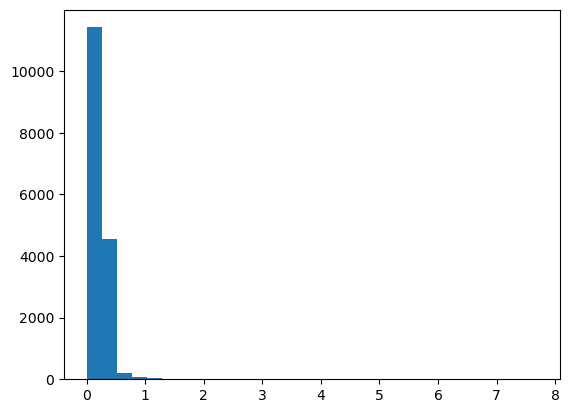

In [254]:
_ = plt.hist(forward_spiral_pred.flatten(), bins=30)

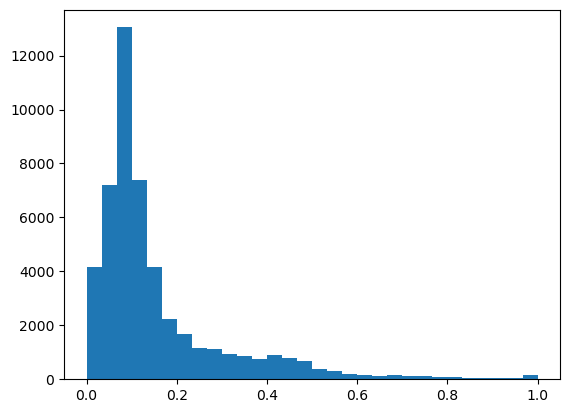

In [255]:
_ = plt.hist(batch['image'][0].flatten(), bins=30)

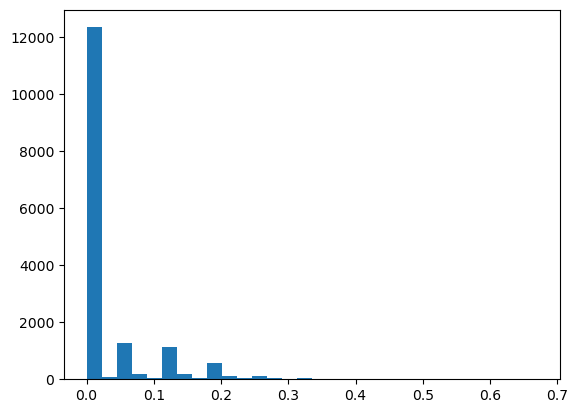

In [256]:
_ = plt.hist(batch['spiral_mask'][0].flatten(), bins=30)